## Makam Recognition Using Pitch Histograms

#### This notebook is prepared by Furkan Yesiler for Music Information Retrieval Winter 2018 lab demonstrations.

In this notebook, we create pitch histograms of given songs and perform a classification task using the values of pitch histogram bins as features. Our dataset includes 10 recordings of 9 makams each. 

We start with importing the necessary libraries.

In [1]:
import os
import csv
import json
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import urllib.request
import zipfile

Downloading pitch data and annotations for a small makam dataset

In [2]:
target_dir = '../../../data/compMusicDatasets/turkishMakam/makamRecognitionSubset/'

#Initialization
url='https://sites.google.com/site/mirspring2018/resources/MakamPitchData.zip?attredirects=0&d=1'
filename='MakamPitchData.zip'
if not os.path.exists(target_dir):#creating the directory
    os.mkdir(target_dir);
#Downloading the zip file from the url
urllib.request.urlretrieve(url,filename)
#Unzipping to a specific folder
zip_ref = zipfile.ZipFile(filename, 'r')
zip_ref.extractall(target_dir)
zip_ref.close()
os.remove(filename)#Removing the zip file
print('Data downloaded and unzipped to: ',target_dir)


Data downloaded and unzipped to:  ../../../data/compMusicDatasets/turkishMakam/makamRecognitionSubset/


We define some functions that we will use for creating and saving histograms.

In [3]:
def convert_to_cent(pitch_freq, tonic):
    """Converting the pitch values from frequency to cent

        Parameters
        ----------
        pitch_freq : numpy.array
            Frequency values of the pitch
        tonic : float or str
            Tonic frequency to use

        Returns
        -------
        cent_val : numpy.array
            Cent values of the pitch relative to the tonic
    """
    cent_val = 1200 * np.log2(pitch_freq / np.float(tonic))

    # folding the values into the range (0, 1200)
    for k in range(0, cent_val.size):
        while cent_val[k] < 0:
            cent_val[k] = cent_val[k] + 1200
        while cent_val[k] >= 1200:
            cent_val[k] = cent_val[k] - 1200

    return {'cent_val': cent_val}

def write_to_csv(file_name, column_names, values):
    """Writing the input data into a csv file

        Parameters
        ----------
        file_name : str
            Name of the csv file
        column_names : numpy.ndarray
            Names of the columns
        values : numpy.ndarray
            Values to write

    """
    target_dir = '../../../data/compMusicDatasets/turkishMakam/makamRecognitionSubset/pitchData/csv_files/'
    if not os.path.exists(target_dir):
        os.mkdir(target_dir)

    with open(target_dir + file_name, 'w') as csv_:
        writer = csv.writer(csv_, dialect='excel')

        writer.writerow(column_names[0])

        if type(values.shape) is tuple:
            (n, _) = values.shape
        else:
            n = values.size
        for k in range(0, n):
            writer.writerow(values[k])

def load_data(features_csv='../../../data/compMusicDatasets/turkishMakam/makamRecognitionSubset/pitchData/csv_files/feature_values.csv',
                class_csv='../../../data/compMusicDatasets/turkishMakam/makamRecognitionSubset/pitchData/csv_files/class_values.csv'):
    """Loading data from csv files

        Parameters
        ----------
        features_csv : str
            Name of the file that contains feature values
        class_csv : str
            Name of the file that contains class values

        Returns
        -------
        features : numpy.ndarray
            Feature values obtained from the file
        classes : numpy.ndarray
            Class values obtained from the file
    """
    features = \
        Normalizer(norm='max').fit_transform(pd.read_csv(features_csv))
    classes = np.ravel(pd.read_csv(class_csv))

    return {'features': features,
            'classes': classes}

def plot_confusion_matrix(classes, pred_classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """This function prints and plots the confusion matrix

        Parameters
        ----------
        classes : numpy.ndarray
            True class values of the data
        pred_classes : numpy.ndarray
            Predicted class values
        title : str
            Title of the plot
        cmap : plt.cm
            Color map to use for the plot

        """
    cm = confusion_matrix(classes, pred_classes)
    class_names = np.unique(classes)
    plt.figure(figsize=(10, 10),)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Below, we read the files from a given annotations file and load the extracted pitch and tonic values. With dividing the pitch values to tonic, we obtain intervals and we create our pitch histogram with the corresponding values.

In [4]:
# initializing parameters
first_last_pct = True
number_of_columns = 159
number_of_bins = 53
pitch_files = True
pct = 25

folder_dir = target_dir+'pitchData/'

# creating an array for the column names
pitch_column_names = np.ndarray(shape=(1, number_of_columns),
                                dtype='|U16')

# if the analysis includes the first and the last quarter,
# column names are arranged accordingly
if first_last_pct:
    for k in range(0, number_of_bins):
        pitch_column_names[0][k] = 'FreqBin_' \
        + str(k + 1)
        pitch_column_names[0][k + number_of_bins] \
        = 'FreqBin_FQ_' + str(k + 1)
        pitch_column_names[0][k + number_of_bins * 2] \
        = 'FreqBin_LQ_' + str(k + 1)
else:
    for k in range(0, number_of_bins):
        pitch_column_names[0][k] = 'FreqBin_' + str(k + 1)

with open(folder_dir + 'annotations_small.json') as json_data:
    files = json.load(json_data)
    number_of_files = len(files)

    # initializing arrays
    pitch_val = np.ndarray(shape=(number_of_files, number_of_columns))
    class_val = np.ndarray(shape=(number_of_files, 1), dtype='|U16')
    class_column_names = np.ndarray(shape=(1, 1), dtype='|U16')
    class_column_names[0][0] = 'Class'

    count = 0
    # iterate over files
for file in files:
    # checking whether the files are named with MusicBrainz ID
    if isinstance(file['mbid'], str):
        mbid = file['mbid'].split('http://musicbrainz.org/recording/')[-1]
        # checking whether the user has the pitch files
        if pitch_files:
            pitch_freq = np.loadtxt(folder_dir + 'data/'
                                    + file['makam'] + '/' + mbid
                                    + '.pitch')
            tonic = file['tonic']
    # discarding the 0 values
    pitch_freq = pitch_freq[pitch_freq != 0]

    # converting the pitch values from frequency to cent
    cent_val = convert_to_cent(pitch_freq, tonic)['cent_val']

    # creating the histogram based on the number of bins
    hist_val, _ = np.histogram(cent_val, bins=number_of_bins)

    # storing the values of the histogram
    pitch_val[count][:number_of_bins] = hist_val

    # checking if the first and the last quarters are included
    if first_last_pct:
        # taking values of the first and the last quarters
        pitch_freq_fq = pitch_freq[: np.int(pitch_freq.size * (pct / 100))]
        pitch_freq_lq = pitch_freq[np.int(pitch_freq.size * (pct / 100)):]

        # converting the pitch values from frequency to cent
        cent_val_fq = convert_to_cent(pitch_freq_fq, tonic)['cent_val']
        cent_val_lq = convert_to_cent(pitch_freq_lq, tonic)['cent_val']

        # creating the histograms based on the number of bins
        hist_val_fq, _ = np.histogram(cent_val_fq, bins=number_of_bins)
        hist_val_lq, _ = np.histogram(cent_val_lq, bins=number_of_bins)

        # storing the values of the histograms
        pitch_val[count][number_of_bins: (number_of_bins * 2)] \
                        = hist_val_fq
        pitch_val[count][(number_of_bins * 2):(number_of_bins * 3)] = hist_val_lq

    class_val[count][0] = file['makam']

    if count % 10 == 0:
        os.system('clear')
        file_interval = int(10 * np.floor(count / 10))
        print('Files ' + str(file_interval + 1) + '-'
                       + str(file_interval + 10)
                       + ' are being processed')
    count += 1
    
print('Done!')
# writing the values to csv files
write_to_csv('feature_values.csv', pitch_column_names, pitch_val)
write_to_csv('class_values.csv', class_column_names, class_val)

Files 1-10 are being processed
Files 11-20 are being processed
Files 21-30 are being processed
Files 31-40 are being processed
Files 41-50 are being processed
Files 51-60 are being processed
Files 61-70 are being processed
Files 71-80 are being processed
Files 81-90 are being processed
Done!


We load the data and plot the mean histogram values for each makam.

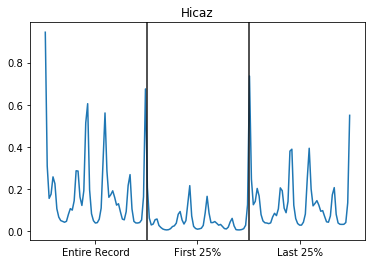

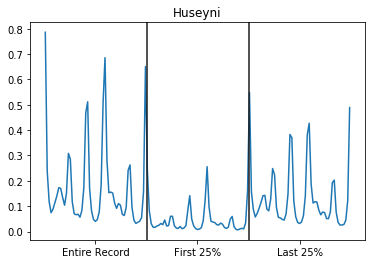

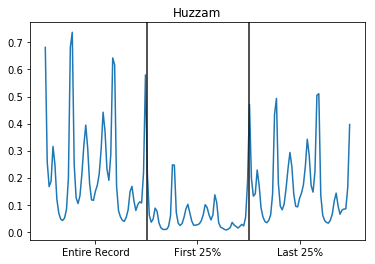

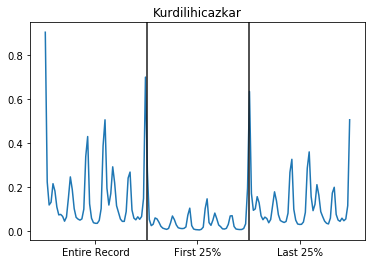

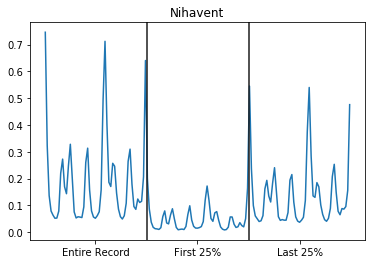

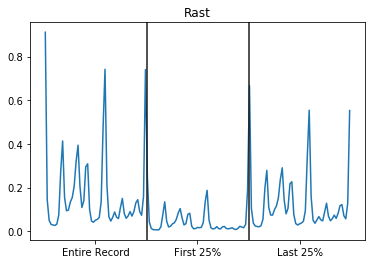

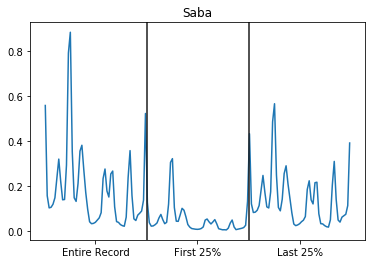

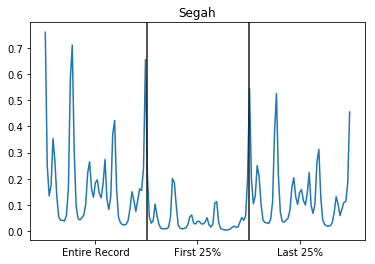

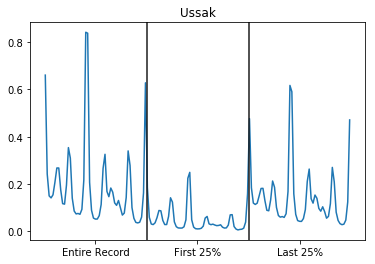

In [5]:
data = load_data()
features = data['features']
classes = data['classes']

labels = ['Entire Record', 'First 25%', 'Last 25%']
lab_index = [26, 79, 132]
for i in range(0,9):
    plt.plot(np.mean(features[i*10:(i+1)*10],axis=0))
    plt.title(np.unique(classes)[i])
    plt.axvline(x=53, color='.1')
    plt.axvline(x=106, color='.1')
    plt.xticks(lab_index, labels)
    plt.show()

Here we divide our dataset into training and test subsets. We perform cross validation on the training subset to tune the hyper-parameters of our model. With the best performing hyper-parameters, we create our model and train it with the training subset. We evaluate the performance of the resulting model on the test subset. The results are given as a confusion matrix.

The accuracy of the test is 0.888888888889


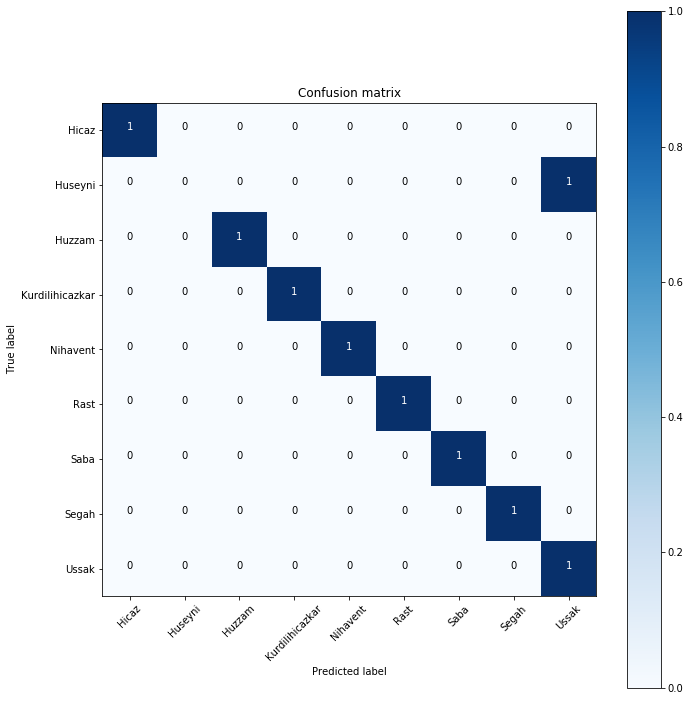

In [6]:
# parameters for grid search
hls=[70]
alps=[0.1]
lrs=[0.001]
i=0

X_train, X_test, y_train, y_test = train_test_split(features, classes, test_size=0.1, stratify=classes, random_state=i)
cvl_r = np.zeros(shape=(len(hls), len(alps), len(lrs)))
j=0
for hl in hls:
    t=0
    for alp in alps:
        m=0
        for lr in lrs:
            model = MLPClassifier(hidden_layer_sizes=hl,
                                  alpha=alp,
                                  learning_rate_init=lr,
                                  max_iter=10000,
                                  momentum=0.5)
        
            cvl = np.mean(np.array(cross_val_score(model,X_train,y_train, 
                                                   cv=StratifiedKFold(n_splits=5, 
                                                                      random_state=i))))
            cvl_r[j][t][m] = cvl
            m += 1
        t += 1
    j += 1
hl_c, alp_c, lr_c = np.unravel_index(np.argmax(cvl_r), cvl_r.shape)
model_2 = MLPClassifier(hidden_layer_sizes=(hls[hl_c],), 
                        alpha=alps[alp_c],
                        learning_rate_init=lrs[lr_c], 
                        max_iter=10000,
                        momentum=0.5)
model_2 = model_2.fit(X_train, y_train)
y_pred = model_2.predict(X_test)

print('The accuracy of the test is '+ str(accuracy_score(y_test,y_pred)))
plot_confusion_matrix(y_test, y_pred)